In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import SimpleRNN, Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

In [2]:
# GPU 할당
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## 0518_1
#### 1차 학습 데이터 6603
- come, away, spin, stop
---
#### 2차 학습 데이터 0518_1_1
- come, away, spin, stop + 0428_1의 x1,x2,x3 덮어씌움
---
#### 파인튜닝 finetune_0521_1
- come : seq_come_1716033507.npy
- away : seq_away_1716033707.npy
- spin : seq_spin_1716034072.npy
- stop : seq_stop_1716034324.npy

In [3]:
# 파인튜닝할 추가 데이터
# 동작 지정
actions = ['come', 'away', 'spin', 'stop']

data = np.concatenate([
    np.load('dataset/0518_1/seq_come_1716033507.npy'),
    np.load('dataset/0518_1/seq_away_1716033707.npy'),
    np.load('dataset/0518_1/seq_spin_1716034072.npy'),
    np.load('dataset/0518_1/seq_stop_1716034324.npy')
], axis=0)

data.shape

date = "finetune_0521_1"

In [4]:
# 기존 데이터
# 마지막에 포함된 라벨 값을 빼기 위해 -1을 함
x_data = data[:, :, :-1]
# 마지막 값을 라벨로 지정
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(21190, 50, 99)
(21190,)


In [5]:
# 기존 데이터
# 원핫인코딩
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(21190, 4)

In [6]:
# 실수형으로 데이터 형식 변환
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

# train, test 데이터 나누기
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(19071, 50, 99) (19071, 4)
(2119, 50, 99) (2119, 4)


In [7]:
# 기존 모델 로드 (필요한 경우)

model = load_model('models/0518_1_1/model.keras')

In [8]:
# 모델 학습 설정
model = Sequential([
    SimpleRNN(64, activation='relu', input_shape=x_train.shape[1:3]),
    # Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

c:\Users\qrstu\anaconda3\envs\python_31010\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,708 (49.64 KB)

 Trainable params: 12,708 (49.64 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)는 검증 데이터 손실(val_loss)이 증가하면,
# 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)한다는 의미
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=30, 
    callbacks=[
        # ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
        ModelCheckpoint('models/{}/model.keras'.format(date), monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/30
594/596 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9818 - loss: 0.2614
Epoch 1: val_acc improved from -inf to 1.00000, saving model to models/finetune_0521_1/model.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - acc: 0.9819 - loss: 0.2603 - val_acc: 1.0000 - val_loss: 3.0656e-07 - learning_rate: 0.0010
Epoch 2/30
588/596 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 1.0000 - loss: 0.0000e+00
Epoch 2: val_acc did not improve from 1.00000
596/596 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 1.0000 - loss: 0.0000e+00 - val_acc: 1.0000 - val_loss: 3.0656e-07 - learning_rate: 0.0010
Epoch 3/30
588/596 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 1.0000 - loss: 0.0000e+00
Epoch 3: val_acc did not improve from 1.00000
596/596 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - acc: 1.0000 - loss: 0.0000e+00 - val_acc: 1.0000 - val_loss: 3.0656e-07 - learning_rate: 0.0010
Epoch 4/30
594/596 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 1.0000 - loss: 0.0000e+00
Epoch 4: val_acc did not improve from 1.00000
596/596 ━━━━━━

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,126 (148.93 KB)

 Trainable params: 12,708 (49.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,418 (99.29 KB)

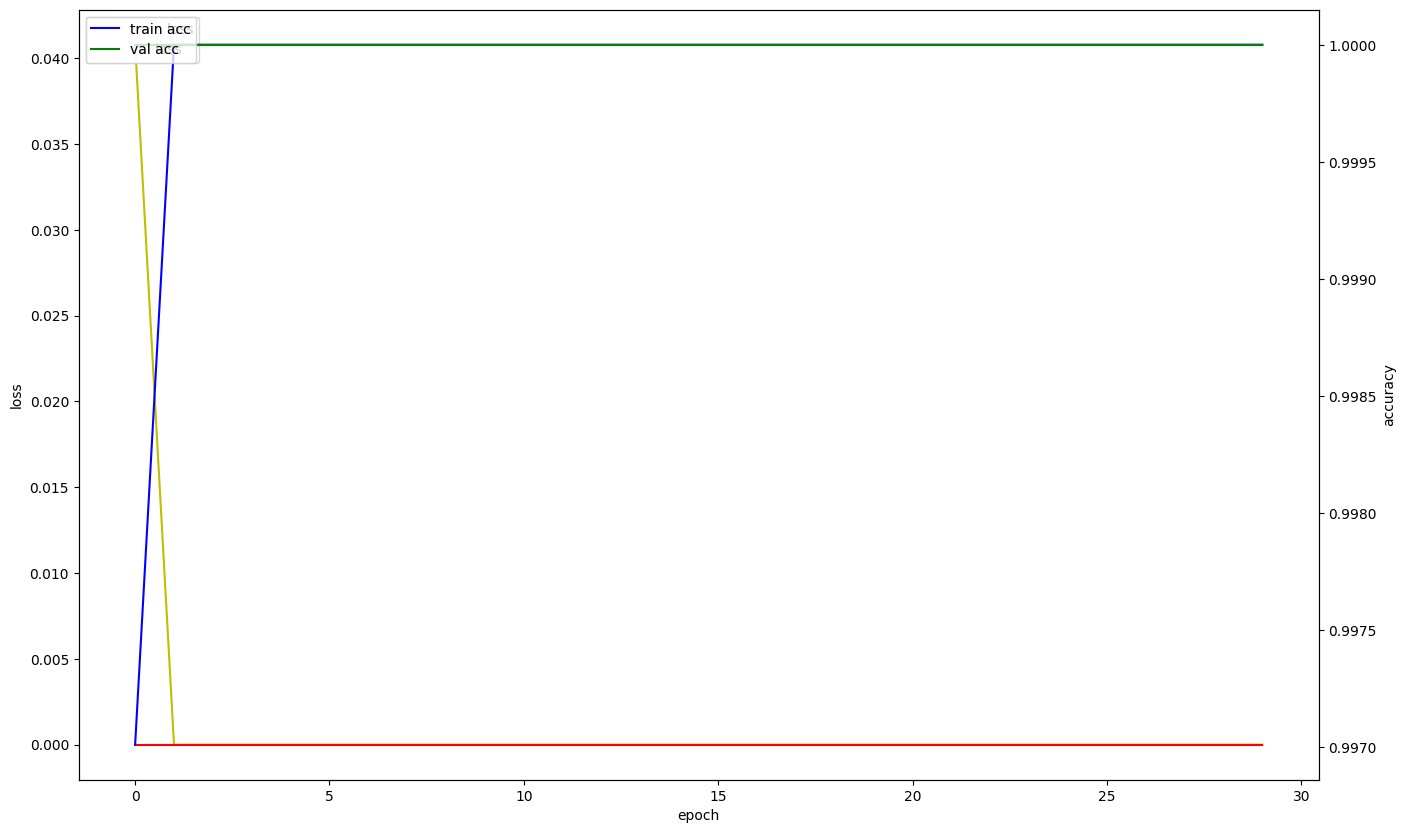

In [11]:
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [12]:
loss, acc = model.evaluate(x_val, y_val)

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 1.0000 - loss: 2.8361e-07


In [13]:
model = load_model('models/{}/model.keras'.format(date))

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


array([[[   0,    0],
        [   0, 2119]]], dtype=int64)